<a href="https://colab.research.google.com/github/marinandres/Episode-2/blob/main/Episode_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Enhancing Demand Forecasting in the Supply Chain Industry with a Hybrid ARIMA and Long Short-Term Memory (LSTM) Model**

Sales prediction for a retail industry

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Data Cleaning**



In [ ]:
df = pd.read_csv('/stats.csv')

columns_drop = ['current_balance', 'total_taxes','document_ID', 'gross_profit','business', 'category', 'item_description', 'document', 'client_name', 'packaging', 'address', 'gross_profit_percentage', 'total_tax_retention']
df = df.drop(columns=columns_drop)

df_indices = df.index[df['item_ID'] == 21].tolist()
df = df.iloc[df_indices]

df['delivery_price'] = df['delivery_price'].fillna(0)

df["client_ID"] = df["client_ID"].astype(int)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head()

,unit_cost,sold_quantity,total_cost,unit_price,total_sale_price,delivery_price,amount_paid,payment_dates,client_ID,item_ID,year_extracted,month_extracted,day_extracted
date,,,,,,,,,,,,,
2020-01-04,9.54,1.0,9.54,15.8,15.8,0.0,16.906,2020-01-04 00:00:00,1141,21,2020,1,4
2020-01-08,9.54,10.0,95.40,15.9,159.0,0.0,170.130,2020-01-08 00:00:00,188,21,2020,1,8
2020-01-21,9.54,5.0,47.70,15.9,79.5,0.0,85.065,2020-01-23 00:00:00,188,21,2020,1,21
2020-01-24,9.54,6.0,57.24,15.9,95.4,0.0,102.078,2020-01-27 00:00:00,1664,21,2020,1,24
2020-02-11,9.54,1.0,9.54,21.5,21.5,0.0,23.005,2020-02-11 00:00:00,1433,21,2020,2,11


In [ ]:
all_dates = pd.date_range(start=df.index.min(), end=df.index.max())

missing_dates = all_dates.difference(df.index)

for missing_date in missing_dates:
    df.loc[missing_date] = 0

df = df.sort_index()
df.head()

,unit_cost,sold_quantity,total_cost,unit_price,total_sale_price,delivery_price,amount_paid,payment_dates,client_ID,item_ID,year_extracted,month_extracted,day_extracted
date,,,,,,,,,,,,,
2020-01-04,9.54,1.0,9.54,15.8,15.8,0.0,16.906,2020-01-04 00:00:00,1141,21,2020,1,4
2020-01-05,0.00,0.0,0.00,0.0,0.0,0.0,0.000,0,0,0,0,0,0
2020-01-06,0.00,0.0,0.00,0.0,0.0,0.0,0.000,0,0,0,0,0,0
2020-01-07,0.00,0.0,0.00,0.0,0.0,0.0,0.000,0,0,0,0,0,0
2020-01-08,9.54,10.0,95.40,15.9,159.0,0.0,170.130,2020-01-08 00:00:00,188,21,2020,1,8


**Visualization**

[Text(0.5, 0, 'Order Date'), Text(0, 0.5, 'Item Sales')]

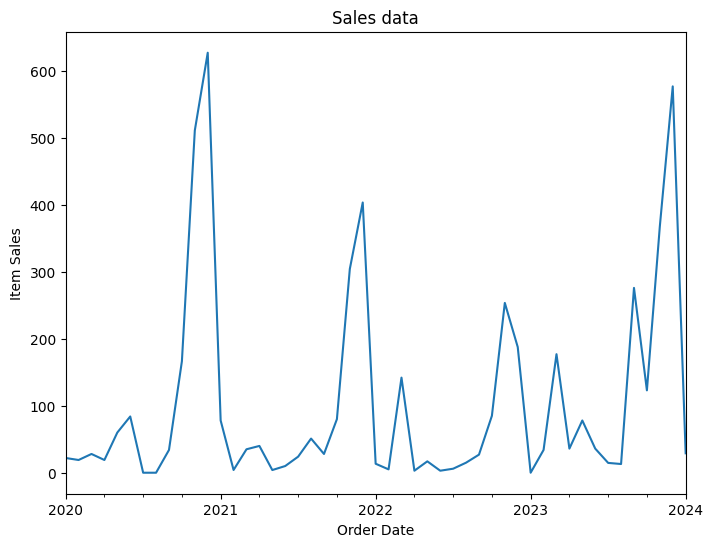

In [ ]:
df['sold_quantity'] = pd.to_numeric(df['sold_quantity'], errors='coerce')
sold_quantity = df['sold_quantity']
sold_quantity = sold_quantity.resample('MS').sum()

x_label = 'Order Date'
y_label = 'Item Sales'
title = "Sales data"

ax = sold_quantity.plot(title=title, figsize=(8, 6))
ax.set(xlabel=x_label, ylabel=y_label)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_cost,2363.0,4.118713,4.375143,0.0,0.0,5.140,5.440,13.40
sold_quantity,2363.0,2.180103,6.232841,0.0,0.0,1.000,2.000,120.00
total_cost,2363.0,16.732893,49.282458,0.0,0.0,5.140,13.400,1260.00
unit_price,2363.0,8.628118,8.153712,0.0,0.0,14.500,15.900,40.70
total_sale_price,2363.0,33.895255,93.153308,0.0,0.0,14.500,35.700,1902.00
delivery_price,2363.0,0.230639,0.882323,0.0,0.0,0.000,0.000,6.00
amount_paid,2348.0,36.389164,99.671453,0.0,0.0,15.515,38.199,2035.14
client_ID,2363.0,507.523064,613.969740,0.0,0.0,160.000,1049.500,1867.00
item_ID,2363.0,11.277613,10.473382,0.0,0.0,21.000,21.000,21.00
year_extracted,2363.0,1085.622937,1008.205265,0.0,0.0,2020.000,2022.000,2024.00


In [ ]:
max_date = df.index.max()
min_date = df.index.min()

print(f"Maximum order date is {max_date}")
print(f"Minimum order date is {min_date}")
print(f"Total time span is around {(max_date.year - min_date.year)} years")

Maximum order date is 2024-01-11 00:00:00
Minimum order date is 2020-01-04 00:00:00
Total time span is around 4 years


**Time Series Data Analysis**

Summary of Smoothing Techniques

Exponentially Weighted Moving Average (EWMA): Smooths the data using exponential weighting, with recent observations getting more weight.

Simple Exponential Smoothing (SES): Applies a simple exponential smoothing technique to the data.

Double Exponential Smoothing (DES): Incorporates trend information in addition to the level.

Triple Exponential Smoothing (TES): Adds seasonality to the model, along with level and trend.

These techniques are used to smooth time series data, making it easier to identify underlying patterns and trends. The plot will show how each smoothing technique approximates the original sales data (sold_quantity).

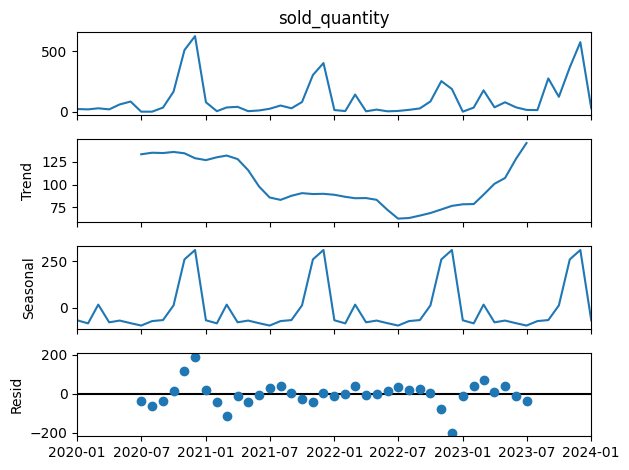

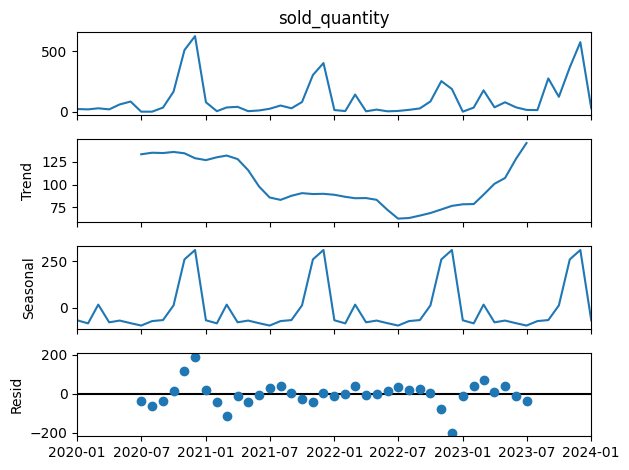

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sold_quantity, model='additive')
decomposition.plot()

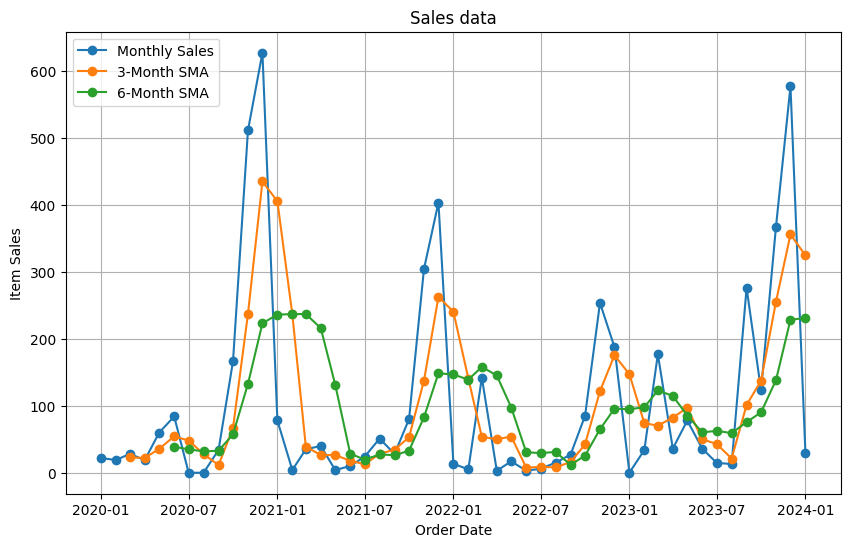

In [ ]:
quarterly_SMA = sold_quantity.rolling(window=3).mean()
semester_SMA = sold_quantity.rolling(window=6).mean()

x_label = 'Order Date'
y_label = 'Item Sales'
title = "Sales data"

plt.figure(figsize=(10, 6))
plt.plot(sold_quantity, label='Monthly Sales', marker='o')
plt.plot(quarterly_SMA, label='3-Month SMA', marker='o')
plt.plot(semester_SMA, label='6-Month SMA', marker='o')

plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.grid(True)
plt.show()

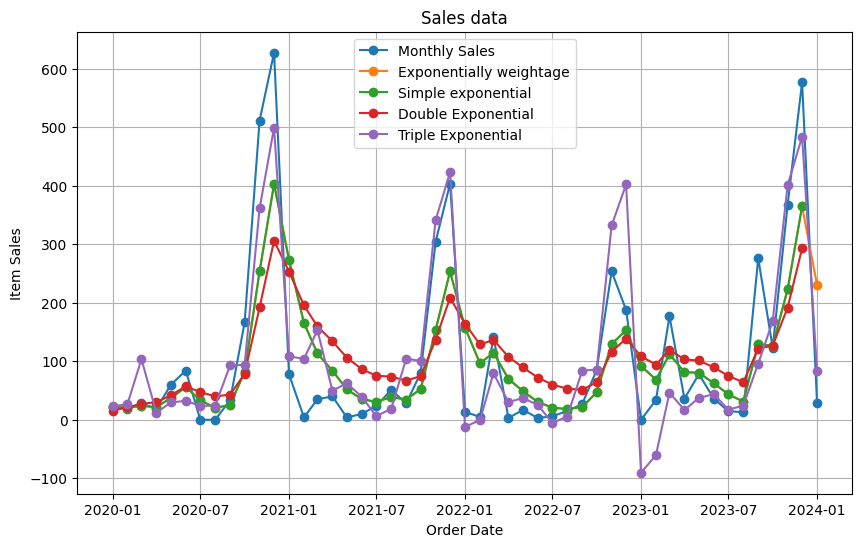

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 4
# Define alpha
alpha = 2/(span+1)

# Exponentially weightage moving average using pandas
EWMA3 = sold_quantity.ewm(alpha=alpha, adjust=False).mean()
# Simple exponential smoothing
SES3 = SimpleExpSmoothing(sold_quantity).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
# Double Exponential Smoothing
DESAdd = ExponentialSmoothing(sold_quantity, trend='add').fit().fittedvalues.shift(-1)
# Triple Exponential Smoothing
TESAdd = ExponentialSmoothing(sold_quantity, trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues


plt.figure(figsize=(10, 6))
plt.plot(sold_quantity, label='Monthly Sales', marker='o')
plt.plot(EWMA3, label='Exponentially weightage', marker='o')
plt.plot(SES3, label='Simple exponential', marker='o')
plt.plot(DESAdd, label='Double Exponential', marker='o')
plt.plot(TESAdd, label='Triple Exponential', marker='o')


plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.grid(True)
plt.show()

**ARIMA Model**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import arma_order_select_ic

d2 = diff(sold_quantity, k_diff=2)

result = adfuller(d2.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print("Lag Used: ", result[2])
print("Observation: ", result[3])
print('Critical Values:', result[4])

# Check if the series is stationary
if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

ADF Statistic: -5.823514197263882
p-value: 4.1300433956278735e-07
Lag Used:  10
Observation:  36
Critical Values: {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}
The series is stationary.


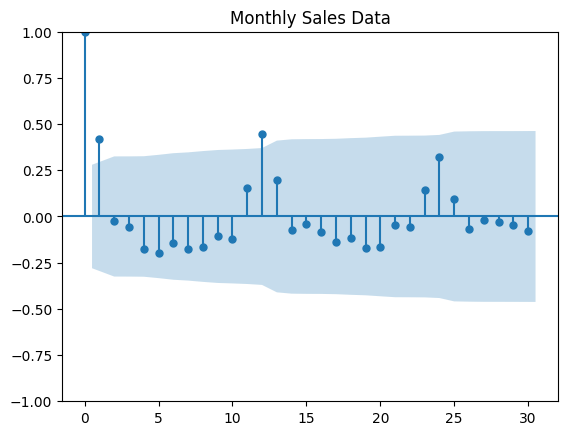

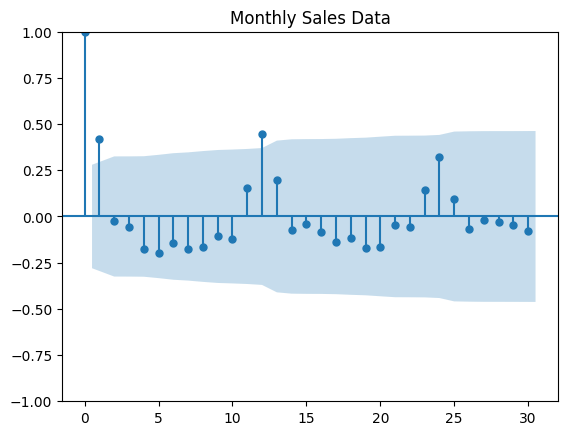

In [ ]:
title = 'Monthly Sales Data'
lags = 30
plot_acf(sold_quantity,title=title,lags=lags)

In [ ]:
res = arma_order_select_ic(sold_quantity, ic=['aic', 'bic'], trend='c')
print("AIC:", res.aic_min_order)
print("BIC:", res.bic_min_order)

AIC: (1, 2)
BIC: (0, 1)


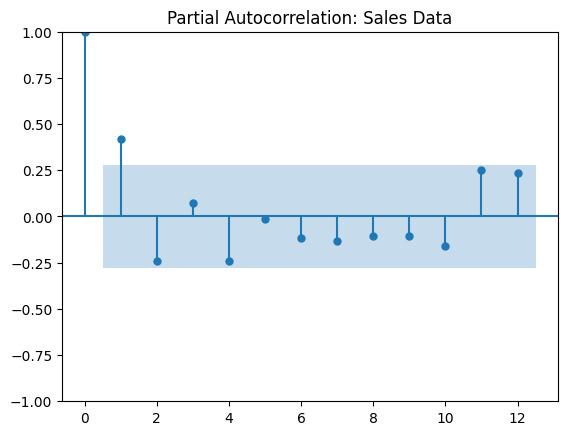

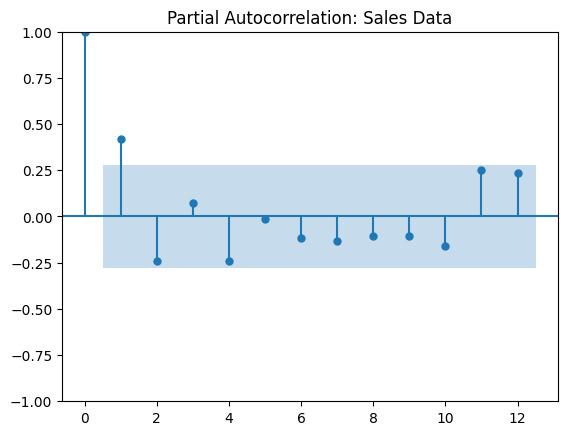

In [ ]:
title = 'Partial Autocorrelation: Sales Data'
lags = 12
plot_pacf(sold_quantity,title=title,lags=lags)

In [ ]:
X = sold_quantity
train, test = X[0:42], X[43:49]

model_arima = ARIMA(train, order=(1,0,1))
model_arima_fit = model_arima.fit()

model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          sold_quantity   No. Observations:                   42
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -257.550
Date:                Fri, 05 Jul 2024   AIC                            523.100
Time:                        22:58:24   BIC                            530.051
Sample:                    01-01-2020   HQIC                           525.648
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.8451     47.789      1.817      0.069      -6.820     180.511
ar.L1          0.0953      0.208      0.459      0.647      -0.312       0.503
ma.L1          0.6455      0.285      2.266      0.023       0.087       1.204
sigma2      1.222e+04   2799.263      4.364      0.000    6729.698    1.77e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                10.87
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.90
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = 0
end = len(train)-1
arima_prediction = model_arima_fit.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,1) Predictions')

arima_prediction

date
2020-01-01     86.845091
2020-02-01     53.725710
2020-03-01     60.861055
2020-04-01     61.108122
2020-05-01     53.763261
2020-06-01     88.277928
2020-07-01     83.822205
2020-08-01     24.537281
2020-09-01     62.737810
2020-10-01     63.261629
2020-11-01    161.075125
2020-12-01    353.277666
2021-01-01    315.147861
2021-02-01    -67.087238
2021-03-01    124.901098
2021-04-01     23.868337
2021-05-01     92.794114
2021-06-01     21.628313
2021-07-01     72.014440
2021-08-01     49.859743
2021-09-01     84.164832
2021-10-01     44.979502
2021-11-01    108.800133
2021-12-01    233.738100
2022-01-01    226.614658
2022-02-01    -57.782979
2022-03-01    119.574013
2022-04-01    106.578904
2022-05-01     11.988687
2022-06-01     83.423290
2022-07-01     26.936765
2022-08-01     65.624144
2022-09-01     47.317272
2022-10-01     68.025541
2022-11-01     97.627079
2022-12-01    203.414071
2023-01-01     86.288552
2023-02-01     22.864527
2023-03-01     88.996983
2023-04-01    152.24

[Text(0.5, 0, 'Order Date'), Text(0, 0.5, 'Sales Data')]

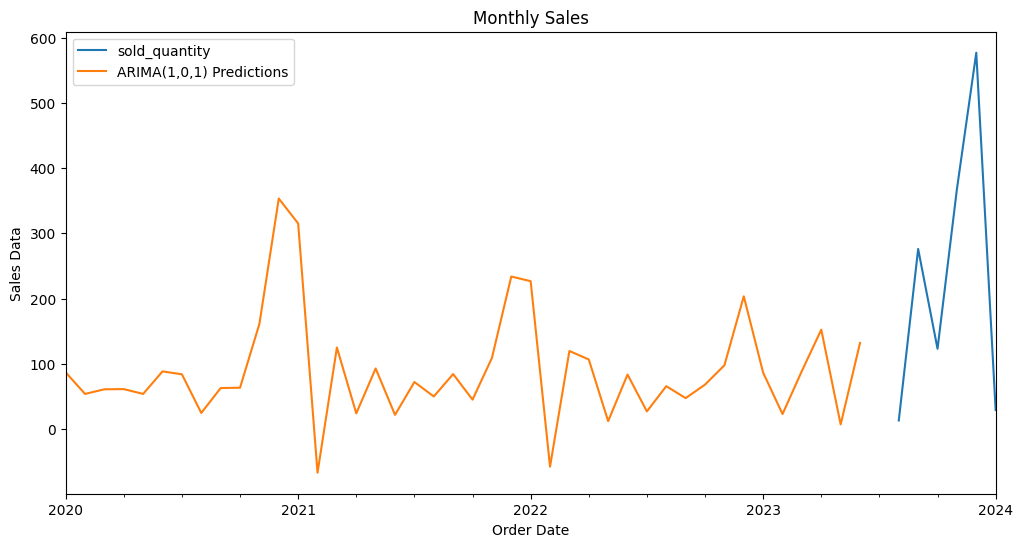

In [ ]:
title = 'Monthly Sales'
ylabel='Sales Data'
xlabel='Order Date'

ax = test.plot(legend=True,figsize=(12,6),title=title)
arima_prediction.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

**Hybrid Model Arquitecture**

Model Summary

This function prints a summary of the model's architecture, including the layers, output shapes, and the number of parameters.
Detailed Explanation of Each Layer's Role

*   First LSTM Layer:

Processes the input sequence and returns the entire sequence of outputs. This helps the model to learn temporal dependencies in the input data over multiple time steps.

*   Dropout Layer:

Helps prevent overfitting by randomly setting a fraction (0.1% in this case) of input units to 0 at each update during training.

*  Second LSTM Layer:

Further processes the sequence, but returns only the output of the last time step. This condenses the temporal information learned from the previous layer into a single output vector.

*  First Dense Layer:

Adds non-linearity to the model with the ReLU activation function. It helps the model to learn complex patterns in the data.

*  Second Dense Layer:

Outputs the final prediction. Since it's a regression task (predicting sold quantities), a single linear output neuron is used

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

lstm_model = Sequential()

lstm_model.add(LSTM(units=10, return_sequences=True, input_shape=(train.shape[0],1)))
lstm_model.add(Dropout(0.001))

lstm_model.add(LSTM(units=10))

lstm_model.add(Dense(8, 'relu'))
lstm_model.add(Dense(1, 'linear'))

lstm_model.compile(optimizer=Adam(learning_rate=0.0003), loss= 'mean_squared_error')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 42, 10)            480       
                                                                 
 dropout_2 (Dropout)         (None, 42, 10)            0         
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_4 (Dense)             (None, 8)                 88        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1417 (5.54 KB)
Trainable params: 1417 (5.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
X_train = arima_prediction
Y_train = train

lstm_model.fit(X_train, Y_train, batch_size=2, epochs=500)

Epoch 1/500
21/21 [==============================] - 0s 4ms/step - loss: 13402.9922
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 13665.2549
Epoch 3/500
21/21 [==============================] - 0s 4ms/step - loss: 13478.0986
Epoch 4/500
21/21 [==============================] - 0s 4ms/step - loss: 13594.6230
Epoch 5/500
21/21 [==============================] - 0s 4ms/step - loss: 13482.2617
Epoch 6/500
21/21 [==============================] - 0s 4ms/step - loss: 13477.9004
Epoch 7/500
21/21 [==============================] - 0s 5ms/step - loss: 13448.2529
Epoch 8/500
21/21 [==============================] - 0s 6ms/step - loss: 13359.4834
Epoch 9/500
21/21 [==============================] - 0s 7ms/step - loss: 13592.0547
Epoch 10/500
21/21 [==============================] - 0s 6ms/step - loss: 13657.2520
Epoch 11/500
21/21 [==============================] - 0s 5ms/step - loss: 13444.6963
Epoch 12/500
21/21 [==============================] - 0s 4ms/step - loss: 

In [ ]:
Y_predicted = lstm_model.predict(test)

1/1 [==============================] - 0s 23ms/step


In [ ]:
Y_predicted_series = pd.Series(Y_predicted.flatten(), index=test.index, name='predicted_quantity')

[Text(0.5, 0, 'Order Date'), Text(0, 0.5, 'Sales Data')]

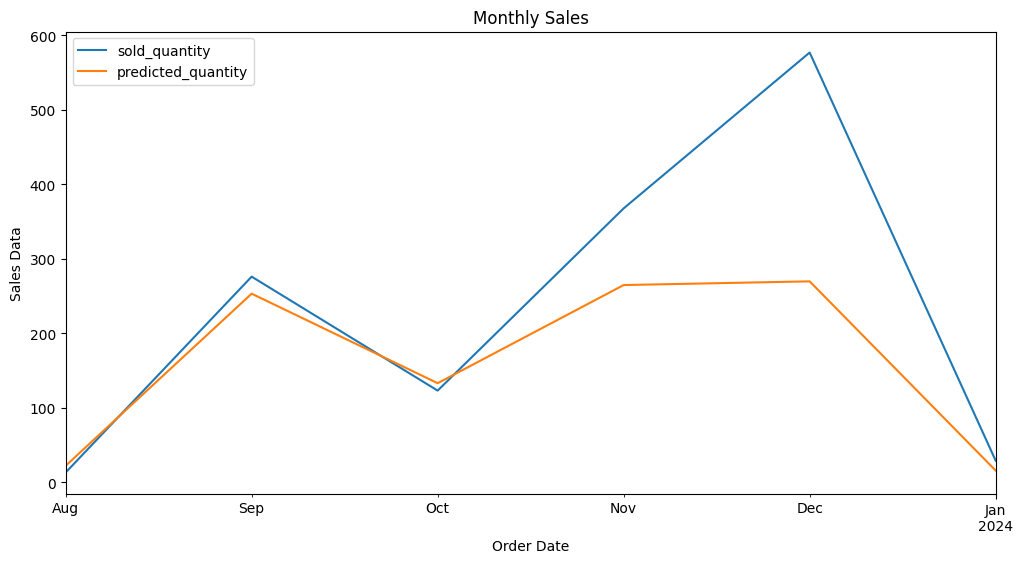

In [ ]:
title = 'Monthly Sales'
ylabel='Sales Data'
xlabel='Order Date'

ax = test.plot(legend=True,figsize=(12,6),title=title)
Y_predicted_series.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

**Metrics**

Comparison and Usage

MSE is useful for understanding the overall performance of a model, especially when large errors need to be penalized more heavily.

MAE provides a straightforward interpretation of the average prediction error.
RMSE is often preferred in many applications because it balances the error's scale and penalizes larger errors, making it a good overall metric for model performance.

To contextualize these results, consider the range and scale of your data. For example, if your sold quantities range in the hundreds, an MAE of 77.56 and an RMSE of 132.84 may indicate a significant error, suggesting that the model's predictions can be improved.

In [ ]:
from sklearn.metrics import mean_absolute_error

def model_evaluation(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(MSE)

    print("Mean Squared Error (MSE):", MSE)
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)

model_evaluation(test,Y_predicted_series)

Mean Squared Error (MSE): 17646.02367157387
Mean Absolute Error (MAE): 77.56275309456719
Root Mean Squared Error (RMSE): 132.83833660345897
